In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
from tensorflow.python.keras.applications.vgg16 import VGG16

In [3]:
#loading VGG16 model
model=VGG16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

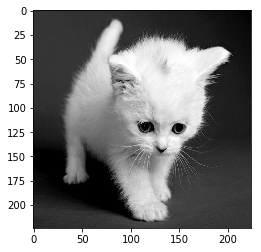

In [4]:
#Open Image, resize and convert to numpy
image=cv2.imread("1.jpg",cv2.IMREAD_COLOR)
image=cv2.resize(image,(224,224))
image=np.array(image)
plt.imshow(image)

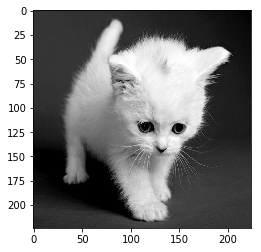

In [5]:
# Blue-Green-red pallete - to classic RGB
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [6]:
#we need it to optimize image for proessing with VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
image = preprocess_input(image.astype('float32'))


In [7]:
#Add image to the batch of one
X=[]
X.append(image)
X=np.array(X)
X.shape

(1, 224, 224, 3)

In [8]:
#For convinience, lets wrap all preprocessing into one function, that preproesses picture and returns batch of one
from tensorflow.keras.applications.vgg16 import preprocess_input
def prep_im(path,shape):
    image=cv2.imread(path,cv2.IMREAD_COLOR)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    image=cv2.resize(image,shape)
    image=np.array(image)
    image = preprocess_input(image.astype('float32'))
    X=[]
    X.append(image)
    X=np.array(X)
    return X
    

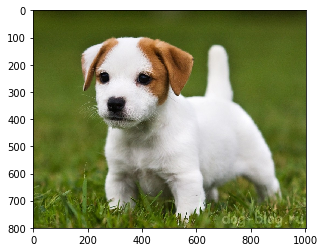

In [9]:
X=prep_im("doggy.jpg",(224,224))


In [10]:
prediction=model.predict(X)
prediction.shape

(1, 1000)

In [11]:
from tensorflow.keras.applications.vgg16 import decode_predictions
label=decode_predictions(prediction)
label

[[('n02099712', 'Labrador_retriever', 0.28990936),
  ('n02088364', 'beagle', 0.14620999),
  ('n02101388', 'Brittany_spaniel', 0.057972856),
  ('n02089973', 'English_foxhound', 0.055826757),
  ('n02093256', 'Staffordshire_bullterrier', 0.050980516)]]

# ========Transfer Learning ===========

In [12]:
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from matplotlib import pyplot as plt


In [13]:
# loading dataset. You can doenload it from https://bit.ly/2WMNENR  or generate with dataset_preparation.ipynb
X_train,X_test,y_train,y_test=np.load("cats_dogs.np.npy")

In [14]:
#preprocessing images for VGG16
X_train_prep=np.array([preprocess_input(p.astype('float32')) for p in X_train])
X_test_prep=np.array([preprocess_input(p.astype('float32')) for p in X_test])

In [15]:
#loading feature extractor
feature_extractor=VGG16(weights='imagenet',
                        include_top=False,
                        input_shape=(100,100,3))

feature_extractor.trainable=False
feature_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [17]:
#creating the model. Feature extractor - then flatten - then 2 fully connected layers and 1 neuron - output
mymodel=Sequential()

mymodel.add(feature_extractor)
mymodel.add(Flatten())
mymodel.add(Dense(512, activation='relu'))
mymodel.add(Dense(256,activation='relu'))
mymodel.add(Dense(1,activation='sigmoid'))

mymodel.compile(loss='binary_crossentropy',
               optimizer='adam')

mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 17,206,081
Trainable params: 2,491,393
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
%%time
#training the model for 5 epochs (try to train mode to have more accuracy, if you have spare time :)
# general trend of validation loss should be decreasing over the epochs. It indicates the progress of the learning

batch_size=64
mymodel.fit(X_train_prep,y_train,
         batch_size=batch_size,
          epochs=5, validation_split=0.1)

Train on 810 samples, validate on 90 samples
Epoch 1/5
810/810 [==============================] - 31s 38ms/step - loss: 3.2606 - val_loss: 4.6330
Epoch 2/5
810/810 [==============================] - 18s 22ms/step - loss: 1.8530 - val_loss: 2.2129
Epoch 3/5
810/810 [==============================] - 18s 22ms/step - loss: 1.1775 - val_loss: 1.9551
Epoch 4/5
810/810 [==============================] - 18s 22ms/step - loss: 1.4098 - val_loss: 1.9905
Epoch 5/5
810/810 [==============================] - 18s 22ms/step - loss: 1.1005 - val_loss: 1.9661
Wall time: 1min 41s


In [19]:
prediction=mymodel.predict(X_test_prep).astype('int')

In [20]:
#Checking the accuracy of the model by comparing predicted labels with ground truth
#Expected accuracy is about 0.9 (90%). If you have arout 0.5 (50%), it means that model does not work.
# try to restart the kernell and try one more time. It helped in the workshop
from sklearn.metrics import accuracy_score
accuracy_score(prediction,y_test)

0.91

In [21]:
#just printing out the labels
(prediction[:,0].astype('int'))

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0])

In [22]:
#Converting 0 and 1 to "cat" and "dog"
pred_labels=["cat" if p==0 else "dog" for p in prediction[:,0]]
true_labels=["cat" if p==0 else "dog" for p in y_test]

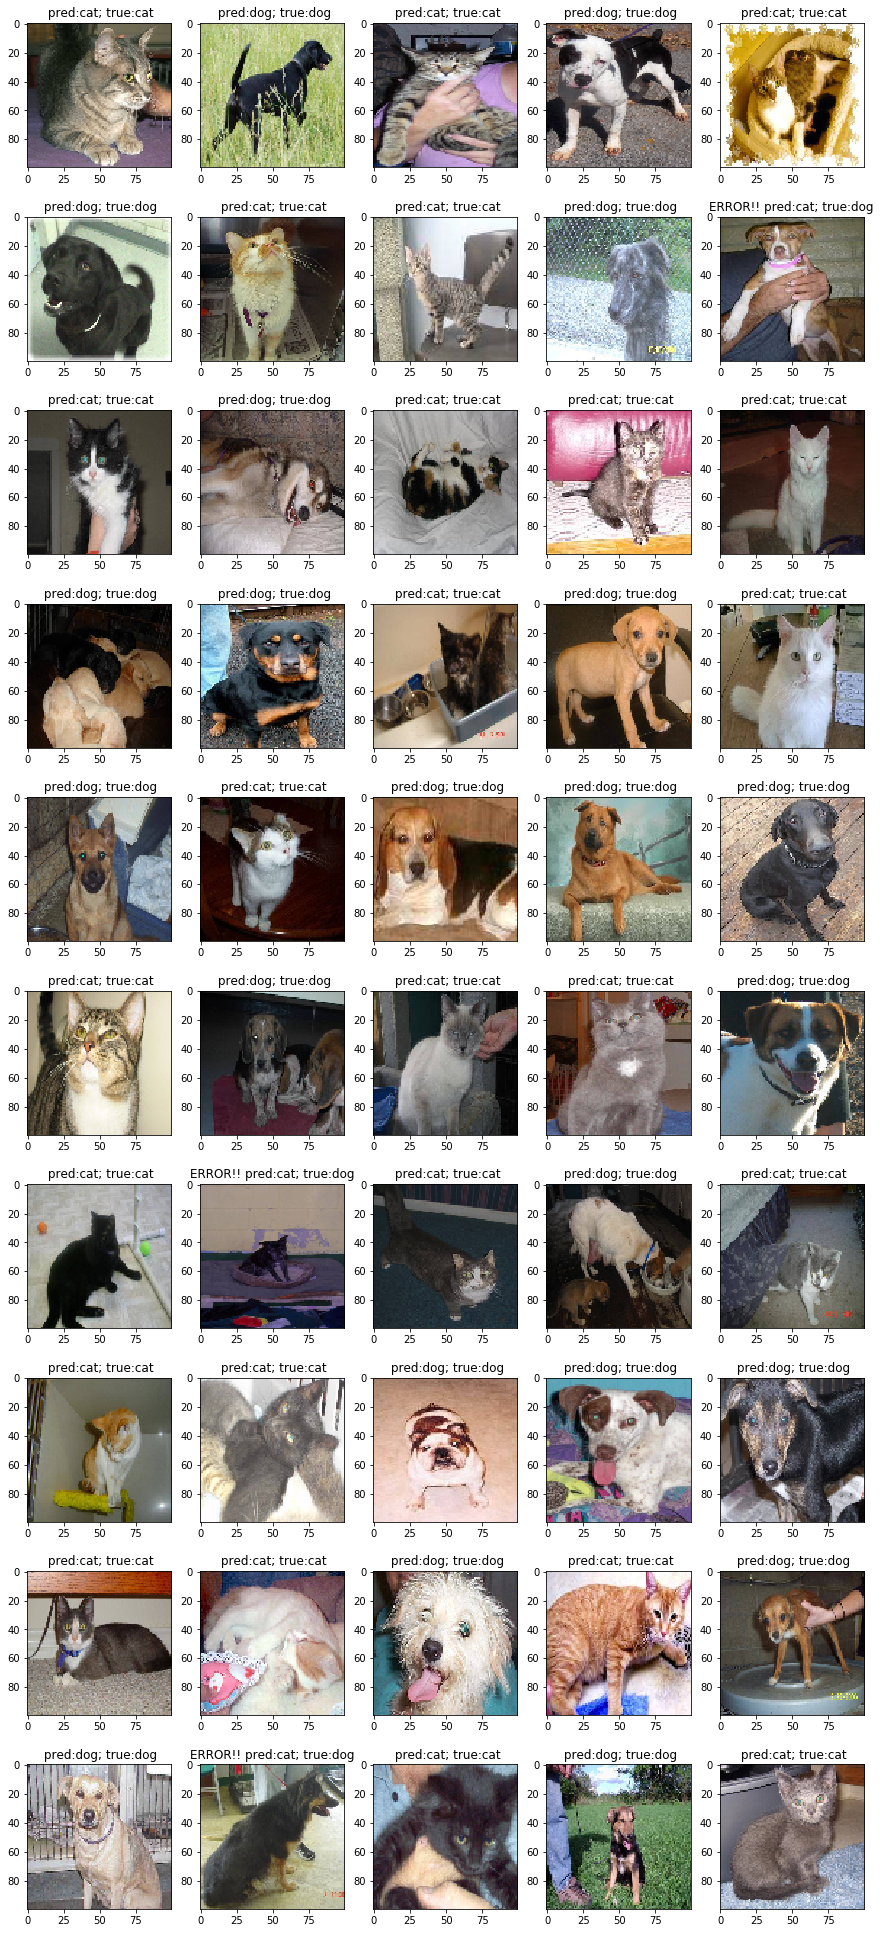

In [23]:
#plotting the images and predictions. Here we can see some errors

#create a plot
fig,axes=plt.subplots(nrows=10,ncols=5,figsize=(15,35))

#fill the plot with images and labels
for i in range(50):
    if pred_labels[i]!=true_labels[i]:
        e="ERROR!!" 
    else: e=""
    axes[i//5,i%5].imshow(X_test[i])
    axes[i//5,i%5].set_title(e+" pred:"+pred_labels[i]+"; true:"+true_labels[i])
    
plt.show()

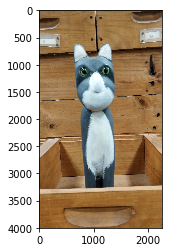

In [30]:
#look! it even works for the cats from the library, 7th level :)
x=prep_im("c1.jpg",(100,100))

In [31]:
mymodel.predict(x)

array([[0.]], dtype=float32)